  ** JING MTA DATA ANALYSIS**

In [5]:
# import required libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
import requests
import re
from bs4 import BeautifulSoup

In [8]:
# find links using regular expression matching date wanted
def geturls(date):
    urls = []
    res = requests.get("http://web.mta.info/developers/turnstile.html")
    soup = BeautifulSoup(res.content, 'lxml')
    links = soup.find_all('a', href=re.compile("data/nyct/turnstile/turnstile_"+date))
    for link in links:
        url = "http://web.mta.info/developers/"+link.get('href')
        urls.append(url) 
    return urls

In [9]:
# append all dataframe read from urls into one single list 
# get all dates in 2013
dfs = []
for url in geturls('13'):
    dfs.append(pd.read_csv(url, header = None, usecols=range(0, 43))) 

In [10]:
#define a function to rearrange each line in dataframe
#concat dataframes into a single large dataframe of 2013
def dfclean(df):
    ind=df.iloc[:,0:3]
    df1=pd.concat([ind, df.iloc[:,3:8]],axis=1)
    df2=pd.concat([ind, df.iloc[:,8:13]],axis=1)
    df3=pd.concat([ind, df.iloc[:,13:18]],axis=1)
    df4=pd.concat([ind, df.iloc[:,18:23]],axis=1)
    df5=pd.concat([ind, df.iloc[:,23:28]],axis=1)
    df6=pd.concat([ind, df.iloc[:,28:33]],axis=1)
    df7=pd.concat([ind, df.iloc[:,33:38]],axis=1)
    df8=pd.concat([ind, df.iloc[:,38:43]],axis=1)
    listofdf=[df1, df2, df3, df4, df5, df6, df7, df8]
    for i in listofdf:
        i.columns = ['C/A','UNIT','SCP','DATE','TIME','DESC','ENTRIES','EXITS']
    final_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8],axis=0)
    return final_df

In [11]:
# concat dataframes into a single large dataframe of 2013 df_2013
df_2013 = pd.concat([dfclean(i) for i in dfs], axis = 0)

In [13]:
# reset index after Concat and drop unnecessary column 'index'
df_2013 = df_2013.reset_index()
df_2013.drop('index', axis = 1, inplace = True)

In [14]:
# save dataframe into a csv file in order for further possible use
df_2013.to_csv('df_2013.csv')

In [15]:
# import station.csv got from MTA website to load station names
Station = pd.read_csv('Station.csv')

In [16]:
# check if Booth ID's are unique
(Station['Booth'].value_counts() > 1).any()

False

In [17]:
# rename Booth column to C/A for further merger
Station.rename(columns = {'Booth':'C/A'}, inplace = True)

In [18]:
# check if there are missing Booth ID's
df_2013['C/A'].isnull().sum()

0

In [19]:
# merge the df_2013 and Station according to 'C/A' column
df_2013 = pd.merge(df_2013, Station, on = ['C/A'])
df_2013.rename(columns = {'Station':'STATION'}, inplace = True)

In [20]:
# check if there are any missing station Names
df_2013['STATION'].isnull().sum()

0

In [22]:
# remove any duplicates
df_2013 = df_2013.drop_duplicates()

In [23]:
# choose 'DESC' is 'REGULAR'
df_2013 = df_2013[df_2013['DESC'] == 'REGULAR']

In [24]:
# remove rows with missing date and time
df_2013 = df_2013[df_2013['DATE'].notnull()]

In [25]:
# remove rows with missing Entries and Exits
df_2013 = df_2013[df_2013['ENTRIES'].notnull()]
df_2013 = df_2013[df_2013['EXITS'].notnull()]

In [26]:
# add a new column'DATETIME' to easy query by combining date and time
df_2013['DATETIME'] = pd.to_datetime((df_2013['DATE'] + ' ' + df_2013['TIME'])
                                             , format='%m-%d-%y %H:%M:%S')

In [27]:
# remove any 2012 data
df_2013 = df_2013[df_2013['DATETIME'].dt.year != 2012]

In [28]:
# add a new column 'TURNSTILE' as a combination of C/A, UNIT and SCP to make grouping easier
df_2013['TURNSTILE'] = df_2013['C/A'] + '-' + df_2013['UNIT'] + '-' + df_2013['SCP']

In [29]:
# sort 'DATETIME' and then add two new columns 'ENTRIES_DIFF' and 'EXITS_DIFF' which represent incremental changes for ENTRIES and EXITS
def calcDiff(df):
    df = df.sort_values('DATETIME')
    df['ENTRIES_DIFF'] = df.ENTRIES - df.ENTRIES.shift(1) 
    df['EXITS_DIFF'] = df.EXITS - df.EXITS.shift(1) 
    return(df)

In [30]:
# use ['TURNSTILE','STATION'] as key for grouping
# apply function calcDiff to grouped df_2013 for calculating incremental numbers of Entries and Exits
df_2013 = df_2013.groupby(['TURNSTILE','STATION'], as_index=False, group_keys= False).apply(lambda x: calcDiff(x)).reset_index()

In [31]:
# since there are some counters be reset at some time, so the diff has negative values
df_2013.loc[df_2013['ENTRIES_DIFF']<0,].shape

(1418, 17)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1ac25e0208>],
      dtype=object)

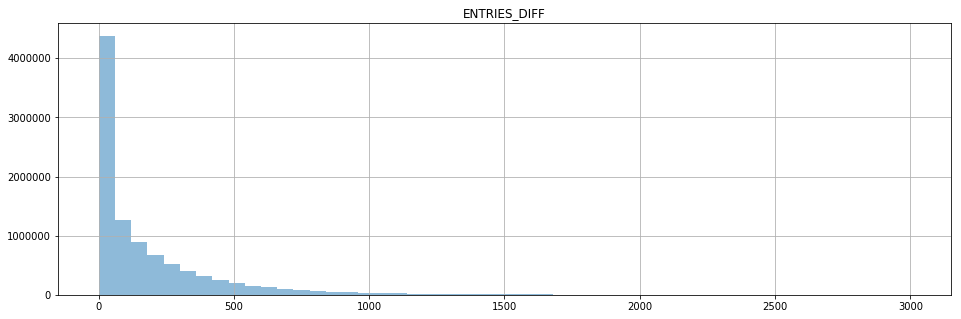

In [41]:
# histogram of ENTRIES_DIFF numbers 
# most values are under 1000
fig = plt.figure(figsize = (16,5))
ax = fig.gca()
df_2013.loc[:,['ENTRIES_DIFF']].hist(range = (0,3000), bins = (50), color = 'tab:blue', alpha = 0.5, ax = ax)
plt.savefig('ENTRIES_DIFF.png', dpi = 1000)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1ac569fb70>],
      dtype=object)

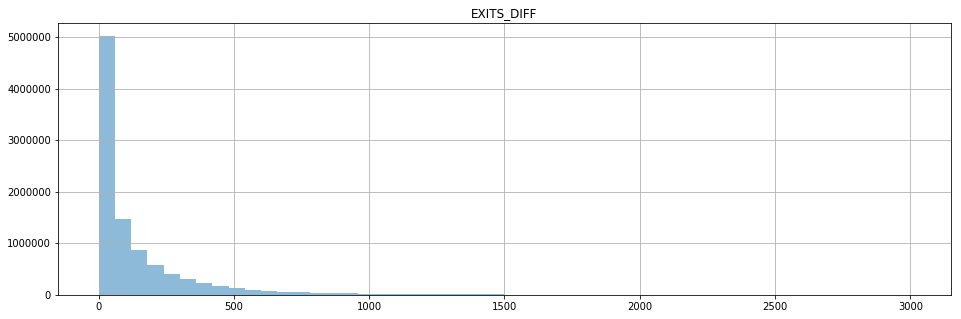

In [42]:
# histogram of DIFFERENCE_EXITS
fig = plt.figure(figsize = (16,5))
ax = fig.gca()
df_2013.loc[:,['EXITS_DIFF']].hist(range = (0,3000), bins = (50), color = 'tab:blue', alpha = 0.5, ax = ax)
plt.savefig('EXITS_DIFF.png', dpi = 1000)

In [44]:
# examine some potential cut-off points for ENTRIES_DIFF
print (df_2013.loc[(df_2013['ENTRIES_DIFF']>1000) & (df_2013['ENTRIES_DIFF']< 2000),].shape)
print (df_2013.loc[(df_2013['ENTRIES_DIFF']>2000) & (df_2013['ENTRIES_DIFF']< 3000),].shape)
print (df_2013.loc[(df_2013['ENTRIES_DIFF']>3000) & (df_2013['ENTRIES_DIFF']< 4000),].shape)
print (df_2013.loc[(df_2013['ENTRIES_DIFF']>4000) & (df_2013['ENTRIES_DIFF']< 5000),].shape)

(182658, 17)
(10469, 17)
(498, 17)
(102, 17)


In [45]:
# examine some potential cut-off points for EXITS_DIFF
print (df_2013.loc[(df_2013['EXITS_DIFF']>1000) & (df_2013['EXITS_DIFF']< 2000),].shape)
print (df_2013.loc[(df_2013['EXITS_DIFF']>2000) & (df_2013['EXITS_DIFF']< 3000),].shape)
print (df_2013.loc[(df_2013['EXITS_DIFF']>3000) & (df_2013['EXITS_DIFF']< 4000),].shape)
print (df_2013.loc[(df_2013['EXITS_DIFF']>4000) & (df_2013['EXITS_DIFF']< 5000),].shape)

(127790, 17)
(12292, 17)
(1889, 17)
(212, 17)


In [46]:
# since there are still around 182k instances between 1000 and 2000, so we would choose 2000 as the cut-off point in order to avoid losing many data points

In [48]:
# Set them to Null
df_2013.loc[df_2013['ENTRIES_DIFF'] < 0, ['ENTRIES_DIFF']] = np.NaN
df_2013.loc[df_2013['ENTRIES_DIFF'] > 2000, ['ENTRIES_DIFF']] = np.NaN

df_2013.loc[df_2013['EXITS_DIFF'] < 0, ['EXITS_DIFF']] = np.NaN
df_2013.loc[df_2013['EXITS_DIFF'] > 2000, ['EXITS_DIFF']] = np.NaN

In [49]:
# add a new column 'BUSYNESS' which is a sum of ENTRIES_DIFF and EXITS_DIFF
df_2013['BUSYNESS'] = df_2013['ENTRIES_DIFF'] + df_2013['EXITS_DIFF']

In [51]:
final_2013 = df_2013

In [52]:
# Save the dataframe in a csv file for further use
final_2013.to_csv('final_2013.csv', index = False)

** Question - 1: Which station has the most number of units? ** 

In [53]:
# get the latest file from MTA website
df18 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180519.txt')

In [54]:
# get the latest day
df18 = df18.set_index('DATE').sort_index(ascending = False)

In [55]:
df18.index

Index(['05/18/2018', '05/18/2018', '05/18/2018', '05/18/2018', '05/18/2018',
       '05/18/2018', '05/18/2018', '05/18/2018', '05/18/2018', '05/18/2018',
       ...
       '05/12/2018', '05/12/2018', '05/12/2018', '05/12/2018', '05/12/2018',
       '05/12/2018', '05/12/2018', '05/12/2018', '05/12/2018', '05/12/2018'],
      dtype='object', name='DATE', length=196733)

In [56]:
# select only 18th May 2018
df_today = df18.loc['05/18/2018',]

In [57]:
# drop duplicate values
df_today = df_today.drop_duplicates()

In [58]:
# select only regular 
df_today = df_today[df_today['DESC']=='REGULAR']

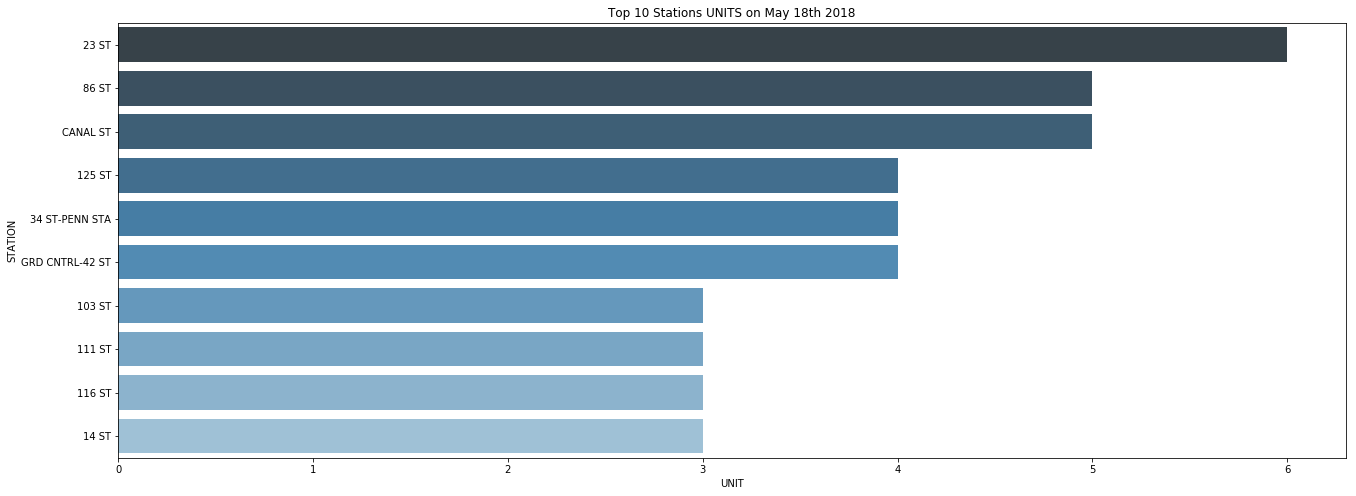

In [59]:
fig = plt.figure(figsize=(22, 8))
plt.title("Top 10 Stations UNITS on May 18th 2018")
graph1Data = df_today.groupby('STATION').agg({"UNIT": lambda x: x.nunique()}).reset_index()
graph1Data = graph1Data.nlargest(10,'UNIT')
sns.barplot(x='UNIT', y="STATION", orient = "h", data=graph1Data, palette="Blues_d")
plt.savefig('TOP10_StationUNITS_May18th2018.png', dpi = 1000)

As the picture shown above, 23 ST station has the most number of units which is 6 in the most recent data.

** Question - 2: What is the total number of entries & exits across the subway system for February 1, 2013? **

In [60]:
# set date as Feb 1, 2013 in final_2013 dataframe
df_20130201 = final_2013[final_2013['DATE'] == '02-01-13']

In [62]:
# calculate the total number of entries & exits
df_20130201['ENTRIES_DIFF'].sum() + df_20130201['EXITS_DIFF'].sum()

9894100.0

The total number of entries & exits across the subway system for Feb 1, 2013 is 9894100.0

** Question - 3: Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date? **

In [65]:
# get the busiest STATION on Feb 1, 2013
df_20130201.groupby('STATION')['BUSYNESS'].sum().sort_values(ascending = False).head(1)

STATION
34 ST-PENN STA    337999.0
Name: BUSYNESS, dtype: float64

In [66]:
# get the busiest TURNSTILE on Feb 1, 2013
df_20130201.groupby('TURNSTILE')['BUSYNESS'].sum().sort_values(ascending = False).head(1)

TURNSTILE
H007-R248-00-00-00    9469.0
Name: BUSYNESS, dtype: float64

In [67]:
# find STATION for this busiest TURNSTILE
df_20130201.loc[df_20130201['TURNSTILE'] == 'H007-R248-00-00-00',['STATION']].head(1)

,STATION
1517934,1 AVE


The busiest Station was 34 ST-PENN STA and the busiest turnstile was H007-R248-00-00-00 which is located in
1 AVE.

** Question - 4: What stations have seen the most usage growth/decline in 2013? **

In [68]:
# add a new column 'WEEK_OF_YEAR' by apply weekofyear to column 'DATEIME' of final_2013 dataframe
final_2013['WEEK_OF_YEAR'] = final_2013['DATETIME'].dt.weekofyear

In [69]:
# group by STATION and WEEK_OF_YEAR apply average mean function to get top 5
final_2013.groupby(['STATION','WEEK_OF_YEAR'])['BUSYNESS'].mean().sort_values(ascending = False).head(5)

STATION      WEEK_OF_YEAR
BEDFORD AVE  42              1070.334520
             25              1065.117438
             19              1063.947368
             16              1053.270073
             24              1050.953901
Name: BUSYNESS, dtype: float64

In [70]:
df_Usage = final_2013.groupby(['STATION','WEEK_OF_YEAR'])['BUSYNESS'].mean().reset_index()

In [73]:
df_Usage = df_Usage.sort_values(by = ['STATION','WEEK_OF_YEAR'])

In [74]:
# convert 0 to 0.1 for BUSYNESS
df_Usage.loc[df_Usage['BUSYNESS'] == 0,'BUSYNESS'] = 0.1
# calculate PCT_CHANGE of usage
df_Usage['PCT_CHANGE'] = df_Usage.groupby('STATION')['BUSYNESS'].pct_change()

In [75]:
# get mean of PCT_CHANGE and select top 10
df_Usage.groupby('STATION')['PCT_CHANGE'].mean().sort_values(ascending = False).head(10)

STATION
BEACH 90 ST        9.975452
WAKEFIELD-241      5.013114
KNICKERBOCKER      4.862987
BEACH 98 ST        4.008699
ORCHARD BEACH      1.816741
AQUEDUCT TRACK     1.427910
BEACH 105 ST       1.348558
SMITH-9 ST         1.246259
ROCKAWAY PK 116    1.065740
BROAD CHANNEL      0.434098
Name: PCT_CHANGE, dtype: float64

In [76]:
# select tail 10
df_Usage.groupby('STATION')['PCT_CHANGE'].mean().sort_values(ascending = False).tail(10)

STATION
4 AVE             -0.002218
BEDFORD AVE       -0.002305
FT HAMILTON PKY   -0.002819
NASSAU AV         -0.003308
9 AVE             -0.003466
FRESH POND ROAD   -0.003527
FRANKLIN AVE      -0.003604
GROVE STREET      -0.004683
AQUEDUCT-N CNDT   -0.006704
LGA AIRPORT CTB         NaN
Name: PCT_CHANGE, dtype: float64

In [79]:
# the PCT_CHANGE for LGA AIRPORT CTB station is NaN, it seems like the station only has data for one week in 2013
df_Usage.loc[df_Usage['STATION'] == 'LGA AIRPORT CTB', ]

,STATION,WEEK_OF_YEAR,BUSYNESS,PCT_CHANGE
14296,LGA AIRPORT CTB,50,480.214286,NaN


The station that has the seen the most growth is BEACH 90 ST.

The station that has seen the least growth is AQUEDUCT-N CNDT.

** Question - 5: What dates in 2013 are the least busy? Could you identify days in 2013 on which stations were not operating at full capacity or closed entirely? **

In [83]:
# group by DATE and take mean of busyness per day
final_2013.groupby('DATE')['BUSYNESS'].mean().sort_values(ascending=False).head(3)

DATE
10-18-13    401.466419
05-10-13    395.667566
10-17-13    393.398188
Name: BUSYNESS, dtype: float64

The top 3 days that were most busy are:

<br>18th October 2013 </br>
10th May 2013 
17th October 2013 

In [93]:
df_capacity = final_2013.groupby(['STATION','DATE'])['BUSYNESS'].mean().reset_index()

In [94]:
# know the statistical fact about daily busyness
df_capacity.groupby('DATE')['BUSYNESS'].mean().describe()

count    361.000000
mean     299.834741
std       68.312340
min      124.452827
25%      231.393306
50%      332.274373
75%      356.118492
max      373.539665
Name: BUSYNESS, dtype: float64

In [95]:
# define days not operating on full as busyness below 50% of total daily values.
df_capacity_notfull = df_capacity.groupby('DATE')['BUSYNESS'].agg('mean').reset_index()
df_capacity_notfull = df_capacity_notfull[df_capacity_notfull['BUSYNESS'] <= 298]
df_capacity_notfull = df_capacity_notfull.sort_values(by = 'DATE')
# after sort by date, it seems to be period rule on the date. they are seem to be weekends

# create a new cloumn names 'DAY_OF_WEEK'
df_capacity_notfull['DATETIME'] = pd.to_datetime(df_capacity_notfull['DATE'], format = '%m-%d-%y')
df_capacity_notfull['DAY_OF_WEEK'] = df_capacity_notfull['DATETIME'].dt.dayofweek

# count the date not operating in full capacity by day of week
df_capacity_notfull.groupby(['DAY_OF_WEEK'])['DATE'].count().sort_values(ascending = False)

DAY_OF_WEEK
6    51
5    51
0     9
4     3
3     3
2     2
1     2
Name: DATE, dtype: int64

In [96]:
# creat a dataframe for turenstiles with 'CLOSE' in DESC
data_close = df_2013.groupby(['DATE','STATION'])['BUSYNESS'].mean().reset_index()

# define the station with daily busyness less than 3 as closed
data_close = data_close[data_close['BUSYNESS'] < 3].groupby('DATE')['STATION'].count().reset_index()

# according to pervious analysis, try to figure out whether number of turnstiles closed is also related to day of week
data_close['DATETIME'] = pd.to_datetime(data_close['DATE'], format = '%m-%d-%y')
data_close['DAY_OF_WEEK'] = data_close['DATETIME'].dt.dayofweek
data_close.groupby(['DAY_OF_WEEK'])['DATE'].count().sort_values(ascending = False)

DAY_OF_WEEK
6    51
5    48
2    38
3    37
1    36
4    35
0    34
Name: DATE, dtype: int64

Some analysis on result
After count the date whose BUSYNESS is below than 50% total values, I found most of the days not operating on full capacity are on Saturday and Sunday;
Also, more turnstiles are closed on Saturday and Sunday, but the difference between weekdays and weekends are not so great compared with stations not operating in full capacity.

** Q6: Bonus: What hour is the busiest for station CANAL ST in Q1 2013? **

In [113]:
final_2013['MONTH'] = final_2013['DATETIME'].dt.month

In [114]:
# get dataframe for 2013 Q1
df_2013Q1 = pd.concat([final_2013[final_2013['MONTH']==1], final_2013[final_2013['MONTH']==2], final_2013[final_2013['MONTH']==3]], axis=0)

In [115]:
# Create a variable to calculate day of week from Date
df_2013Q1['Day_of_Week'] = df_2013Q1['DATETIME'].dt.weekday_name

In [116]:
CANAL_2013Q1=df_2013Q1[df_2013Q1['STATION']=='CANAL ST']

In [117]:
CANAL_2013Q1.groupby('TIME')['BUSYNESS'].mean().sort_values(ascending=False).head(1)

TIME
16:11:49    690.636364
Name: BUSYNESS, dtype: float64

16:11:49 is the busiest hour for station CANAL ST in Q1 2013.

** Question - 7: Plot the daily row counts for data files in Q1 2013. **

In [119]:
# calculate row counts for each data
Row_counts = df_2013Q1.groupby('DATE').count().reset_index()

In [120]:
Row_counts.head()

,DATE,index,C/A,UNIT,SCP,TIME,DESC,ENTRIES,EXITS,Remote,...,Line Name,Division,DATETIME,TURNSTILE,ENTRIES_DIFF,EXITS_DIFF,BUSYNESS,WEEK_OF_YEAR,MONTH,Day_of_Week
0,01-01-13,26140,26140,26140,26140,26140,26140,26140,26140,26140,...,26140,26140,26140,26140,21873,21872,21872,26140,26140,26140
1,01-02-13,26451,26451,26451,26451,26451,26451,26451,26451,26451,...,26451,26451,26451,26451,26398,26389,26351,26451,26451,26451
2,01-03-13,26609,26609,26609,26609,26609,26609,26609,26609,26609,...,26609,26609,26609,26609,26541,26547,26491,26609,26609,26609
3,01-04-13,25640,25640,25640,25640,25640,25640,25640,25640,25640,...,25640,25640,25640,25640,25581,25583,25532,25640,25640,25640
4,01-05-13,26035,26035,26035,26035,26035,26035,26035,26035,26035,...,26035,26035,26035,26035,26005,26011,26003,26035,26035,26035


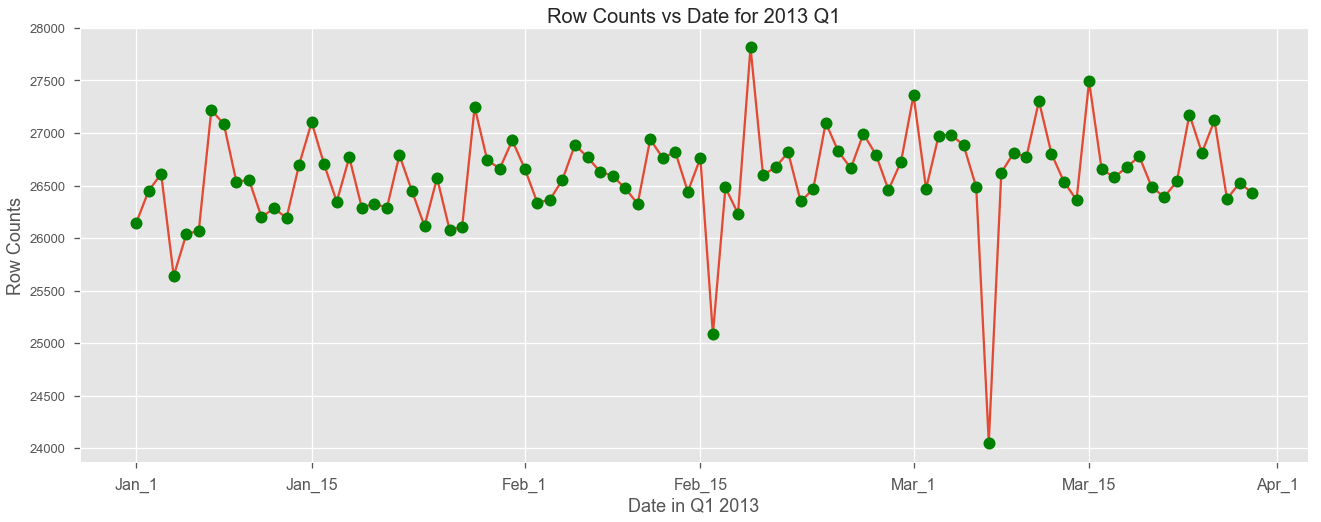

In [144]:
# Plot row counts Vs Date for 2013 Q1
df_2013Q1.sort_values('DATE').groupby('DATE')['DATE'].agg('count').plot(marker = 'o', markersize = 12, markerfacecolor = 'g')
plt.style.use('ggplot')
# set figure size
plt.gcf().set_size_inches(22, 8)
# set title, x label, y label and contents on x coordinate
plt.title('Row Counts vs Date for 2013 Q1', fontsize = 20)
plt.xlabel('Date in Q1 2013', fontsize = 18)
plt.ylabel('Row Counts', fontsize = 18)
plt.xticks([0,14,31,45,62,76,91],['Jan_1','Jan_15','Feb_1','Feb_15','Mar_1','Mar_15','Apr_1'], fontsize=16)
plt.savefig('Row_Counts_2013Q1.png', dpi = 1000)

In [133]:
# a lower point on Mar 10th 2013
df_2013Q1.sort_values('DATE').groupby('DATE')['DATE'].agg('count').sort_values(ascending=True).head(5)

DATE
03-10-13    24051
02-16-13    25086
01-04-13    25640
01-05-13    26035
01-06-13    26071
Name: DATE, dtype: int64

** Question - 8: Plot the daily total number of entries & exits across the system for Q1 2013 **

In [134]:
# group by total entries and exits on date
df_2013Q1_Entries_Exits = df_2013Q1.sort_values('DATE').groupby('DATE')['ENTRIES_DIFF','EXITS_DIFF'].agg('sum')

In [135]:
# rename Columns
df_2013Q1_Entries_Exits.rename(columns = {'ENTRIES_DIFF':'Total Entries', 'EXITS_DIFF':'Total Exits'} ,inplace=True)

([<matplotlib.axis.YTick at 0x1ae0109cf8>,
 <a list of 10 Text yticklabel objects>)

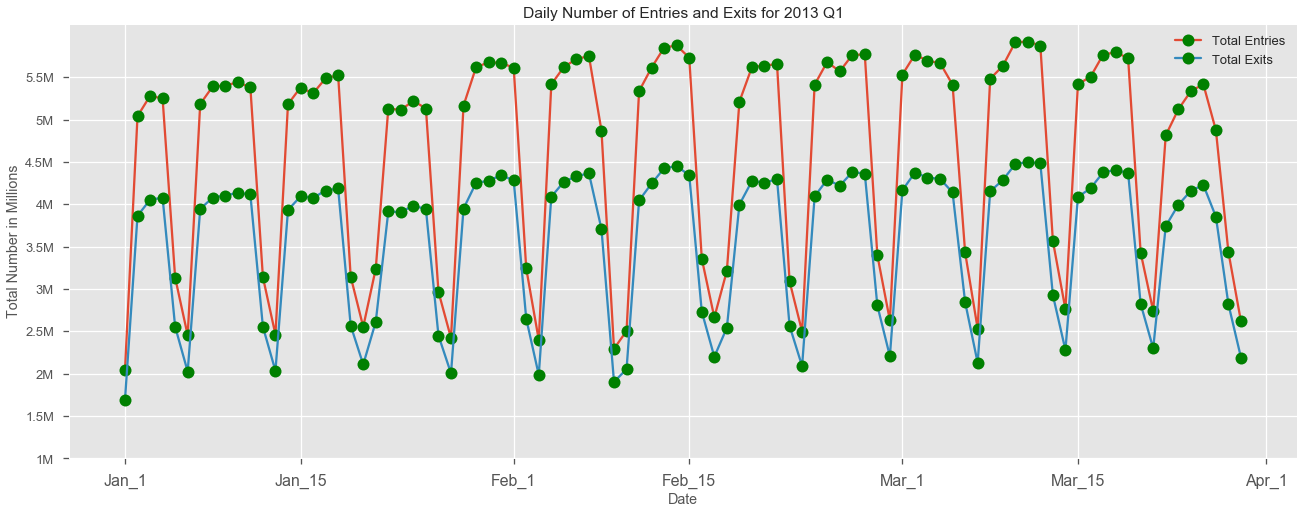

In [143]:
# plotting
plt.style.use('seaborn-talk')
df_2013Q1_Entries_Exits.plot(marker = 'o', markersize = 12, markerfacecolor = 'g')
fig = plt.gcf()
fig.set_size_inches(22, 8, forward=True)
plt.xlabel('Date')
plt.ylabel('Total Number in Millions')
plt.title('Daily Number of Entries and Exits for 2013 Q1')
plt.xticks([0,14,31,45,62,76,91],['Jan_1','Jan_15','Feb_1','Feb_15','Mar_1','Mar_15','Apr_1'], fontsize=16)
plt.yticks((range(1000000,6000000,500000)),['1M','1.5M','2M','2.5M','3M','3.5M','4M','4.5M','5M','5.5M','6M'])
plt.savefig('Daily_number_of_Entries&Exits_2013Q1.png', dpi = 1000)

We can see a pattern here where the daily number drops down on weekends, but picks up again on weekdays.

** Question - 9: Plot the mean and standard deviation of the daily total number of entries & 
exits for each month in Q1 2013 for station 34 ST-PENN STA **

In [240]:
# select data of 34 ST-PENN STA
df_PENN = df_2013Q1[df_2013Q1['STATION'] == '34 ST-PENN STA'].sort_values('MONTH')
# calculate the monthly sum of entries and exits respectively
df_PENN_Totcounts = df_PENN.groupby(['MONTH','DATE'])['ENTRIES_DIFF','EXITS_DIFF'].agg('sum').reset_index()

In [241]:
df_PENN_Totcounts.head()

,MONTH,DATE,ENTRIES_DIFF,EXITS_DIFF
0,1,01-01-13,61601.0,66508.0
1,1,01-02-13,163001.0,131857.0
2,1,01-03-13,168469.0,142746.0
3,1,01-04-13,165642.0,141938.0
4,1,01-05-13,84833.0,78009.0


In [224]:
# calculate monthly mean and std for ENTRIES_DIFF and EXITS_DIFF
PENN_MEANSTD = df_PENN_Totcounts.groupby('MONTH').agg(['mean','std'])

In [225]:
PENN_MEANSTD.columns = ['Total_Entries_Mean','Total_Entries_Std','Total_Exits_Mean','Total_Exits_Std']
PENN_MEANSTD = PENN_MEANSTD.reset_index()

In [226]:
PENN_MEANSTD 

,MONTH,Total_Entries_Mean,Total_Entries_Std,Total_Exits_Mean,Total_Exits_Std
0,1,136716.548387,42486.009265,114752.451613,31002.596351
1,2,139867.321429,45248.037057,117223.785714,34277.103685
2,3,141124.548387,39073.982186,122117.548387,29350.213309


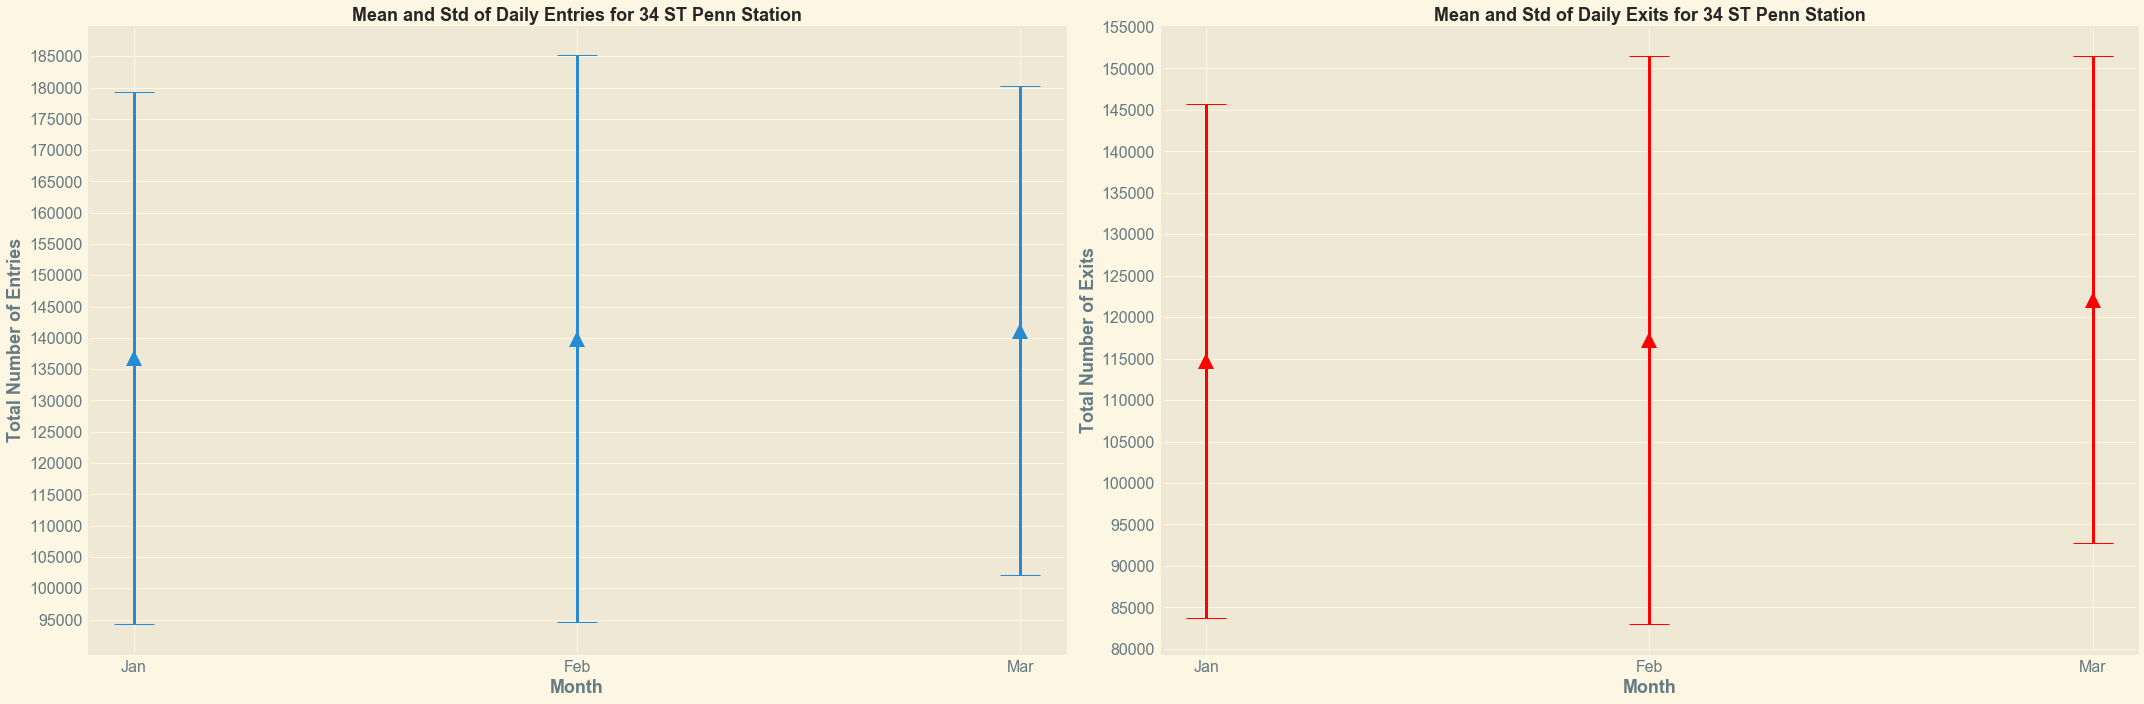

In [256]:
### Plotting for Entries
plt.subplot(1,2,1)
plt.style.use('Solarize_Light2')
fig = plt.gcf()
fig.set_size_inches(30, 10, forward=True)
Month = [1,2,3]
Mean_of_Entries = PENN_MEANSTD['Total_Entries_Mean']
Std_of_Entries = PENN_MEANSTD['Total_Entries_Std']

(_, caps, _) = plt.errorbar(Month, Mean_of_Entries, yerr =  Std_of_Entries, fmt='^', markersize=16, linewidth=3, capsize=20)

for cap in caps:
    cap.set_markeredgewidth(1)

plt.xticks([1,2,3],['Jan','Feb','Mar'], fontsize = 16)
plt.yticks(range(95000,190000,5000), fontsize = 16)
plt.xlabel('Month', fontsize = 18, fontweight='bold')
plt.ylabel('Total Number of Entries', fontsize = 18, fontweight='bold')
plt.title('Mean and Std of Daily Entries for 34 ST Penn Station', fontsize = 18, fontweight='bold')
#plt.show()

### Plotting for Exits
plt.subplot(1,2,2)
Month = [1,2,3]
Mean_of_Exits = PENN_MEANSTD['Total_Exits_Mean'] 
Std_of_Exits = PENN_MEANSTD['Total_Exits_Std']

(_, caps, _) = plt.errorbar(Month, Mean_of_Exits, yerr =  Std_of_Exits, c = 'r',fmt='^', markersize=16, linewidth=3, capsize=20)

for cap in caps:
    cap.set_markeredgewidth(1)

plt.xticks([1,2,3],['Jan','Feb','Mar'], fontsize = 16)
plt.yticks(range(80000,160000,5000), fontsize = 16)
plt.xlabel('Month', fontsize = 18, fontweight='bold')
plt.ylabel('Total Number of Exits', fontsize = 18, fontweight='bold')
plt.title('Mean and Std of Daily Exits for 34 ST Penn Station', fontsize = 18, fontweight='bold')
plt.tight_layout()
plt.savefig('Mean&Std_of_Daily_Entries&Exits_for_34ST_Penn_Station.png', dpi = 1000)


** Question - 10: Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA **

In [229]:
df_PENN_Totcounts.head()

,MONTH,DATE,ENTRIES_DIFF,EXITS_DIFF
0,1,01-01-13,61601.0,66508.0
1,1,01-02-13,163001.0,131857.0
2,1,01-03-13,168469.0,142746.0
3,1,01-04-13,165642.0,141938.0
4,1,01-05-13,84833.0,78009.0


In [230]:
# create data for Entries
Jan_Entries = df_PENN_Totcounts.loc[df_PENN_Totcounts['MONTH'] == 1,['ENTRIES_DIFF']]
Feb_Entries = df_PENN_Totcounts.loc[df_PENN_Totcounts['MONTH'] == 2,['ENTRIES_DIFF']]
Mar_Entries = df_PENN_Totcounts.loc[df_PENN_Totcounts['MONTH'] == 3,['ENTRIES_DIFF']]

data_plot_Entries = [Jan_Entries, Feb_Entries, Mar_Entries]

# create data for Exits
Jan_Exits = df_PENN_Totcounts.loc[df_PENN_Totcounts['MONTH'] == 1,['EXITS_DIFF']]
Feb_Exits = df_PENN_Totcounts.loc[df_PENN_Totcounts['MONTH'] == 2,['EXITS_DIFF']]
Mar_Exits = df_PENN_Totcounts.loc[df_PENN_Totcounts['MONTH'] == 3,['EXITS_DIFF']]

data_plot_Exits = [Jan_Exits, Feb_Exits, Mar_Exits]

In [250]:
df_PENN_plot = df_PENN_Totcounts.groupby('MONTH').sum().reset_index()

In [253]:
data_plot_Entries = df_PENN_plot[['MONTH', 'ENTRIES_DIFF']]
data_plot_Exits = df_PENN_plot[['MONTH', 'EXITS_DIFF']]

([<matplotlib.axis.XTick at 0x1ad63bf470>,
 <a list of 3 Text xticklabel objects>)

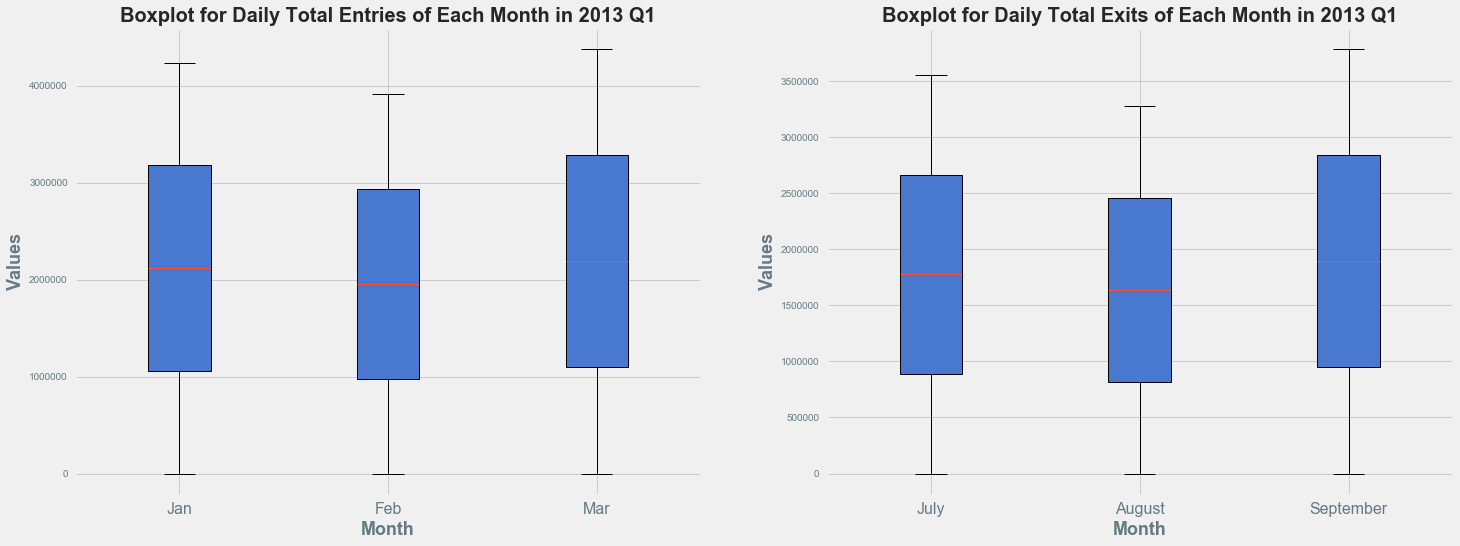

In [277]:
# set up for the figure
plt.style.use('fivethirtyeight')
plt.gcf().set_size_inches(22, 8, forward=True)

# plot boxplot for monthly entries
plt.subplot(1,2,1)
plt.boxplot(data_plot_Entries, patch_artist = True)
plt.title('Boxplot for Daily Total Entries of Each Month in 2013 Q1', fontsize = 20,fontweight='bold')
plt.xlabel('Month', fontsize = 18, fontweight='bold')
plt.ylabel('Values', fontsize = 18, fontweight='bold')
plt.xticks([1,2,3],['Jan', 'Feb', 'Mar'], fontsize=16)


# plot boxplot for monthly exits
plt.subplot(1,2,2)
plt.boxplot(data_plot_Exits, patch_artist = True)
plt.title('Boxplot for Daily Total Exits of Each Month in 2013 Q1', fontsize = 20,fontweight='bold')
plt.xlabel('Month', fontsize = 18, fontweight='bold')
plt.ylabel('Values', fontsize = 18, fontweight='bold')
plt.xticks([1,2,3],['Jan', 'Feb', 'Mar'], fontsize=16)
plt.savefig('25/50/75_percentile_of_Total_Entries&Exits_for_34ST_Penn_Station.png', dpi = 1000)

The red line indicates the median or the 50th percentile, whereas the lower edge and the upper edge of the boxes are the 25th and 75th percentile respectively.

** Question - 11: Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013 **

In [278]:
# group by Station and Date and take mean of Busyness
df_2013Q1.groupby(['STATION','DATE'])['BUSYNESS'].mean().sort_values()

STATION          DATE    
BEACH 90 ST      03-31-13       0.000000
                 03-11-13       0.000000
                 03-09-13       0.000000
KINGSTON AVE     01-20-13       0.000000
                 01-06-13       0.000000
BEACH 90 ST      03-05-13       0.000000
                 03-04-13       0.000000
                 03-03-13       0.000000
                 03-02-13       0.000000
                 03-01-13       0.000000
                 02-28-13       0.000000
                 02-27-13       0.000000
                 02-26-13       0.000000
                 02-25-13       0.000000
                 02-24-13       0.000000
                 02-23-13       0.000000
9TH STREET       01-06-13       0.000000
BEACH 90 ST      02-21-13       0.000000
                 02-18-13       0.000000
                 02-17-13       0.000000
AQUEDUCT TRACK   03-20-13       0.000000
BEACH 90 ST      03-12-13       0.000000
                 03-14-13       0.000000
                 03-15-13      

In [279]:
# We need to determine a cut-off point for average busyness to determine Closed Stations and Stations operating under 
# lower capacity. 
df_2013Q1.groupby(['STATION','DATE'])['BUSYNESS'].mean().describe()

count    33659.000000
mean       295.677174
std        173.745070
min          0.000000
25%        169.974206
50%        271.833333
75%        396.446222
max       2220.000000
Name: BUSYNESS, dtype: float64

The average busyness is around 295, the maximum value is around 2220 and the lowest value is 0. From this we can assume that the stations that are closed have values below 5 and stations operating under lower capacity have values below 50 and greater than 5.

In [280]:
# filter data
df_2013Q1_Station_Busyness = df_2013Q1.groupby(['STATION','DATE'])['BUSYNESS'].mean().reset_index()
df_Closed = df_2013Q1_Station_Busyness[df_2013Q1_Station_Busyness['BUSYNESS'] < 5]
df_Low_Capacity = df_2013Q1_Station_Busyness[(df_2013Q1_Station_Busyness['BUSYNESS'] >= 5) & (df_2013Q1_Station_Busyness['BUSYNESS'] < 50)]

In [281]:
df_Closed.groupby('DATE')['STATION'].agg('count').head(10)

DATE
01-01-13     6
01-02-13     2
01-03-13     2
01-04-13     2
01-05-13     6
01-06-13    21
01-07-13     2
01-08-13     2
01-09-13     2
01-10-13     2
Name: STATION, dtype: int64

In [282]:
df_Low_Capacity.groupby('DATE')['STATION'].agg('count').head(10)

DATE
01-01-13    27
01-02-13     7
01-03-13     7
01-04-13     7
01-05-13    27
01-06-13    24
01-07-13     7
01-08-13     8
01-09-13     7
01-10-13     6
Name: STATION, dtype: int64

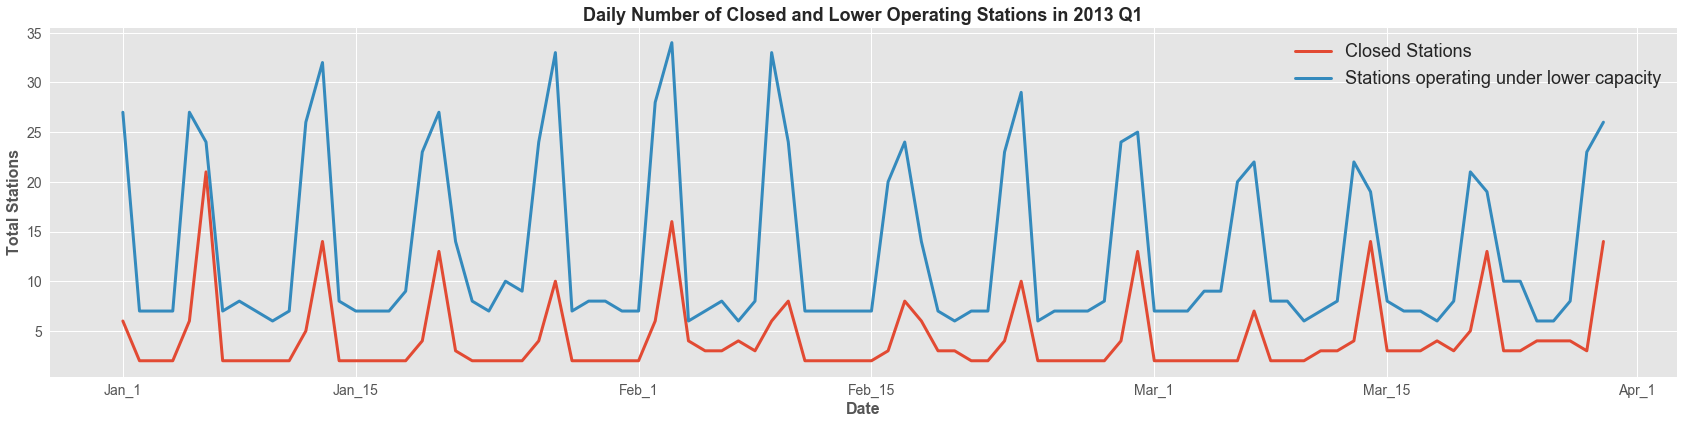

In [303]:
## Plotting
Closed_Count = df_Closed.groupby('DATE')['STATION'].agg('count')
Low_Capacity_Count = df_Low_Capacity.groupby('DATE')['STATION'].agg('count')
Closed_Count.plot(linewidth= 3, label = 'Closed Stations')
Low_Capacity_Count.plot(linewidth= 3, label = 'Stations operating under lower capacity', fontsize = 18)
plt.style.use('ggplot')
fig = plt.gcf()
fig.set_size_inches(26, 6, forward=True)
plt.xlabel('Date', fontsize = 16, fontweight='bold')
plt.ylabel('Total Stations', fontsize = 16, fontweight='bold')
plt.title('Daily Number of Closed and Lower Operating Stations in 2013 Q1', fontsize = 18, fontweight='bold')
plt.xticks([0,14,31,45,62,76,91],['Jan_1','Jan_15','Feb_1','Feb_15','Mar_1','Mar_15','Apr_1'], fontsize=14)
plt.yticks(fontsize = 14)
plt.legend(loc='best', fontsize = 18)
plt.savefig('Daily_Number_of_Closed&Lower_Operating_Stations_2013Q1.png', dpi = 1000)

SELF-ANALYSIS

In [380]:
refined13 = final_2013.groupby(['STATION','TIME']).agg({'BUSYNESS': 'sum'}).reset_index()

In [381]:
TIME2013_100 = refined13.nlargest(100,'BUSYNESS')

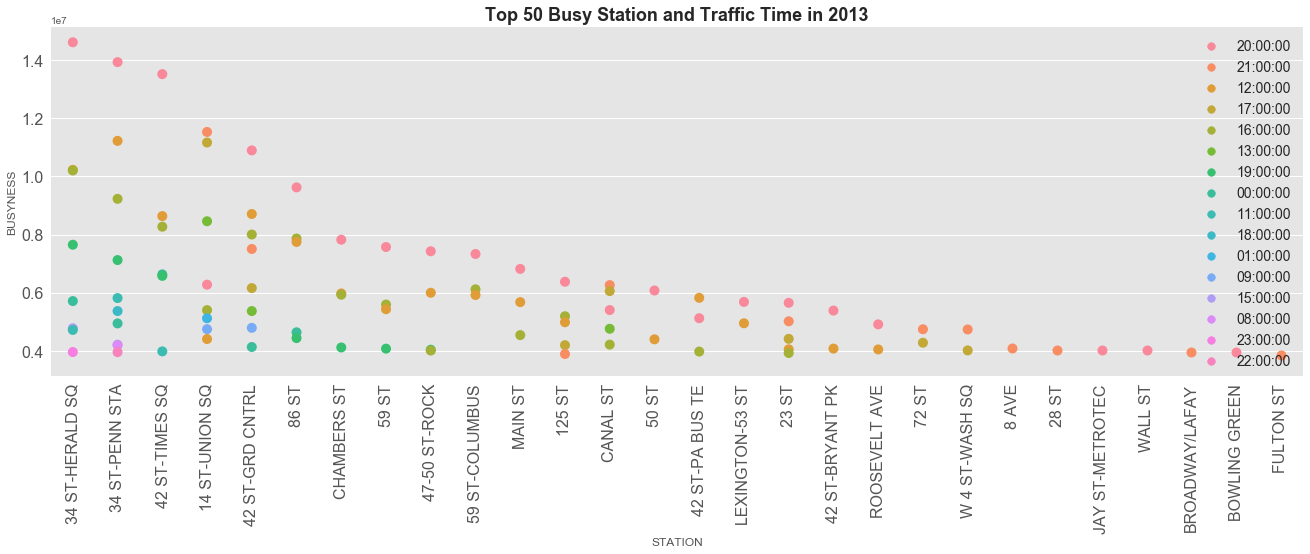

In [382]:
plt.style.use('ggplot')
fig = plt.gcf()
fig.set_size_inches(20, 6, forward=True)
sns.stripplot(x="STATION", y="BUSYNESS", hue="TIME", data = TIME2013_100, size = 10)
plt.xticks(rotation=90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Top 50 Busy Station and Traffic Time in 2013', fontsize = 18, fontweight='bold')
plt.legend(loc='best', fontsize = 14)
plt.savefig('TOP_50_Busy_Station&Time_2013.png', dpi = 1000)

In [ ]:
final_2013['Day_of_Week'] = final_2013['DATETIME'].dt.weekday_name

In [343]:
WEEK_2013 = final_2013.groupby(['STATION','Day_of_Week']).agg({'BUSYNESS': 'sum'}).reset_index()
WEEK2013_50 = WEEK_2013.nlargest(50, 'BUSYNESS')

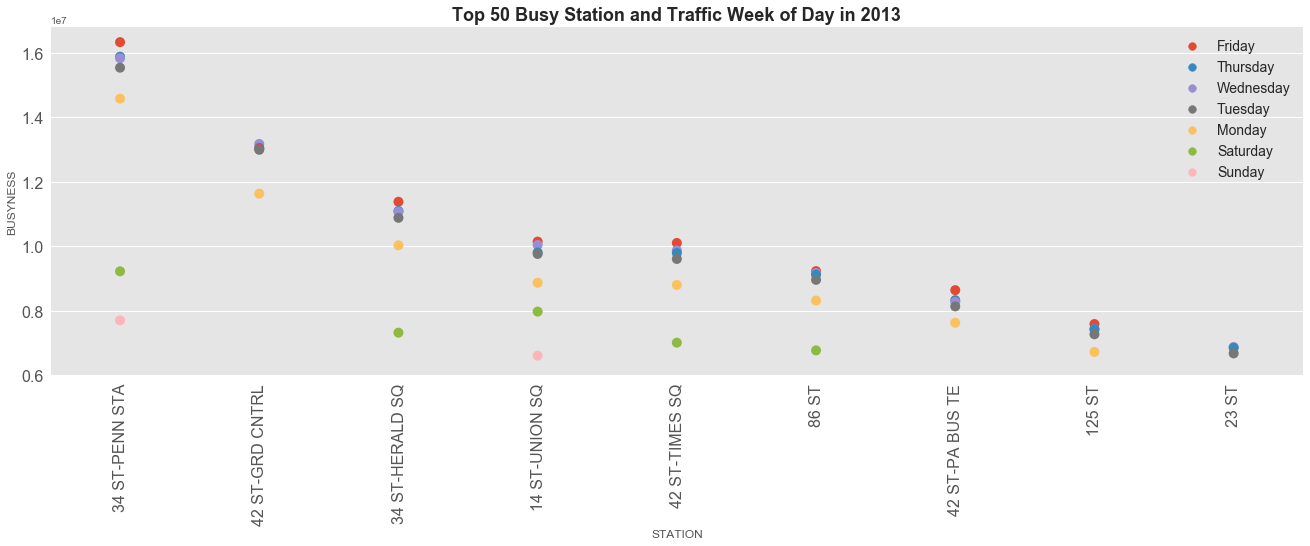

In [346]:
plt.style.use('ggplot')
fig = plt.gcf()
fig.set_size_inches(20, 6, forward=True)
sns.stripplot(x="STATION", y="BUSYNESS", hue="Day_of_Week", data = WEEK2013_50, size = 10)
plt.xticks(rotation=90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Top 50 Busy Station and Traffic Week of Day in 2013', fontsize = 18, fontweight='bold')
plt.legend(loc='best', fontsize = 14)
plt.savefig('TOP_50_Busy_Station&Day_2013.png', dpi = 1000)

In [1]:
DATE_2013 = final_2013.groupby(['STATION','DATE']).agg({'BUSYNESS': 'sum'}).reset_index()
DATE2013_50 = DATE_2013.nlargest(50, 'BUSYNESS')

NameError: name 'final_2013' is not defined

In [ ]:
plt.style.use('ggplot')
fig = plt.gcf()
fig.set_size_inches(20, 6, forward=True)
sns.stripplot(x="DATE", y="STATION", hue="DATE", data = WEEK2013_50, size = 10)
plt.xticks(rotation=90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Top 50 Busy Station and Traffic Week of Day in 2013', fontsize = 18, fontweight='bold')
plt.legend(loc='best', fontsize = 14)
plt.savefig('Busy_Station&Date_2013.png', dpi = 1000)

In [368]:
WEEK_2013 = final_2013.groupby(['STATION','Day_of_Week']).agg({'BUSYNESS': 'sum'}).reset_index()
WEEK2013_100 = WEEK_2013.nlargest(100, 'BUSYNESS')

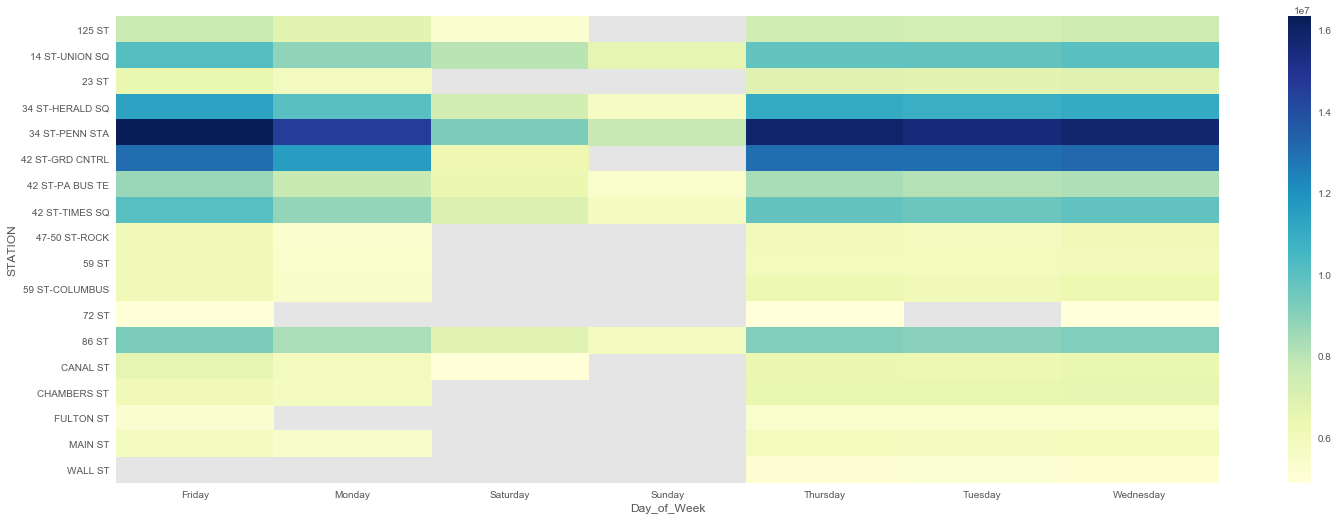

In [370]:
plt.subplots(figsize=(22, 8))
data_day = WEEK2013_100.pivot("STATION", "Day_of_Week", "BUSYNESS")
sns.heatmap(data_day, cmap = 'YlGnBu')
plt.savefig('HEATMAP.png', dpi = 400)
plt.savefig('Busy_Station&Day_2013_heatmap.png', dpi = 1000)

In [371]:
MONTH_2013 = final_2013.groupby(['STATION','MONTH']).agg({'BUSYNESS': 'sum'}).reset_index()
MONTH2013_100 = MONTH_2013.nlargest(100, 'BUSYNESS')

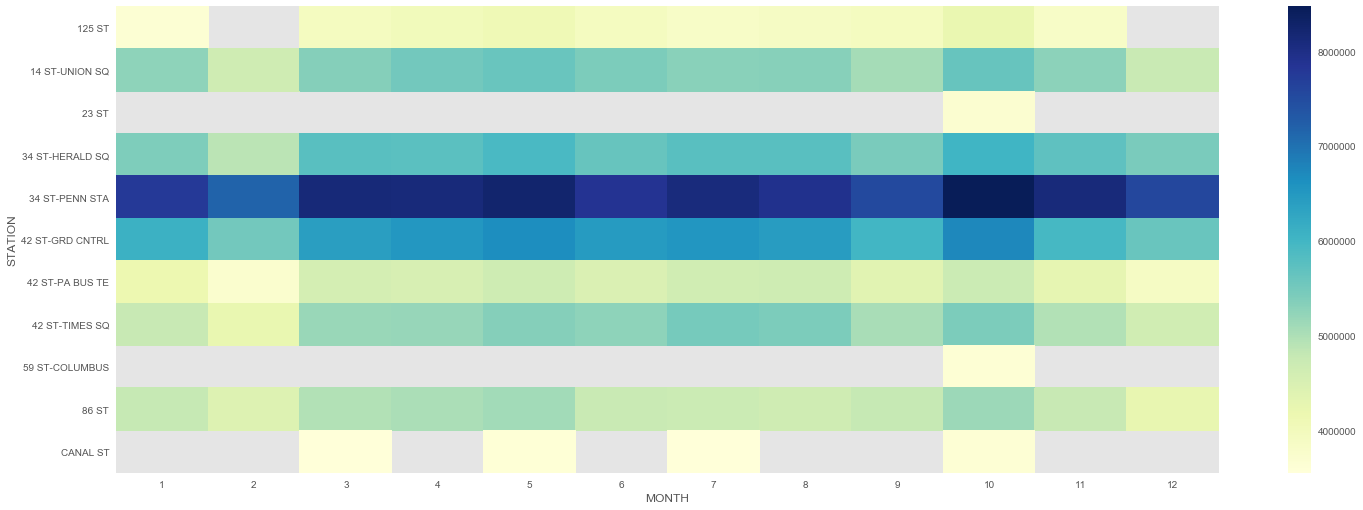

In [373]:
plt.subplots(figsize=(22, 8))
MONTH = MONTH2013_100.pivot("STATION", "MONTH", "BUSYNESS")
sns.heatmap(MONTH, cmap = 'YlGnBu')
plt.savefig('HEATMAP_MONTH.png', dpi = 400)
plt.savefig('Busy_Station&Month_2013_heatmap.png', dpi = 1000)

In [378]:
TIME_2013 = final_2013.groupby(['STATION','TIME']).agg({'BUSYNESS': 'sum'}).reset_index()
TIME2013_50 = TIME_2013.nlargest(50, 'BUSYNESS')

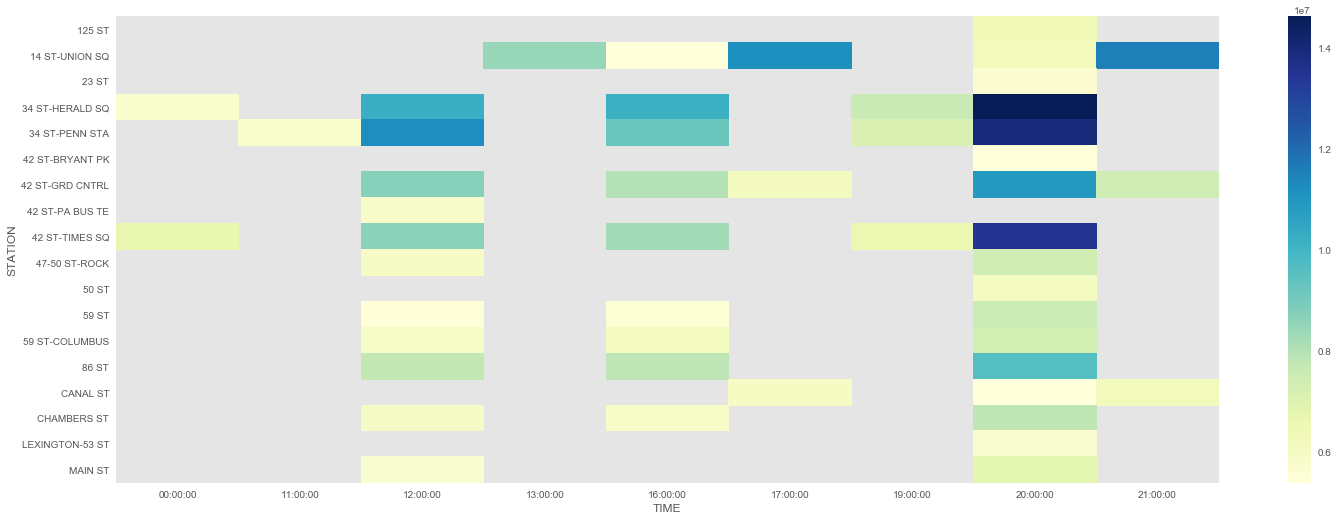

In [379]:
plt.subplots(figsize=(22, 8))
TIME = TIME2013_50.pivot("STATION", "TIME", "BUSYNESS")
sns.heatmap(TIME, cmap = 'YlGnBu')
plt.savefig('Busy_Station&Time_2013_heatmap.png', dpi = 400)

In [ ]:
g=sns.PairGrid(df_2013)
g.map(plt.scatter)
plt.savefig('PAIRGRID2013.png')